# Reseau et résultat de prélèvement pour une adresse

In [1]:
# %pip install numpy pandas matplotlib geopandas

In [2]:
import os
import socket
import pandas as pd
import numpy as np
import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
from shapely.geometry import Point


proxies = {'http': 'http://cache.ritac.i2:32000', 'https': 'http://cache.ritac.i2:32000'} \
          if '10.112' in socket.gethostbyname(socket.gethostname()) else {}
geoapi_key = os.getenv('GEOAPI_KEY') or open('.geoapi_key').read()[:-1]



def search_address(address):
    result = requests.get(f'https://api.geoapify.com/v1/geocode/search?text="{address}"&apiKey={geoapi_key}', proxies=proxies)
    if result.status_code == 200:
        d = result.json()
        try:
            return d['features'][0]  # first adress to appear
        except (ValueError, IndexError):
            raise  # TODO: exception, adress not found

def get_code_reseau(df, point, field='c_ins_code'):
    return df.loc[df.contains(point), field].values[0]

def get_info_reseau(code_reseau):
    result = requests.get(f'https://hubeau.eaufrance.fr/api/vbeta/qualite_eau_potable/communes_udi?code_reseau={code_reseau}&annee=2021')
    if result.status_code == 200:
        return result.json()
    
def get_dernier_prelevement(code_reseau):
    result = requests.get(f'https://hubeau.eaufrance.fr/api/vbeta/qualite_eau_potable/resultats_dis?code_reseau={code_reseau}&code_parametre=1340&size=1&fields=libelle_parametre,code_lieu_analyse,resultat_numerique,libelle_unite,date_prelevement&sort=desc')
    if result.status_code in (200, 206):
        return result.json()['data'][0]

In [3]:
bretagne_2016 = gpd.read_file("data/AtlaSante_Bretagne/ars_r53_bretagne_udi_2016_jointure.json")
df = bretagne_2016

In [4]:
address = "Gare SNCF, Rennes, France"
# address = "Hotel de Ville, Saint Malo, France"

Adresse: Boulevard Magenta, Rennes, France
Coordonnées: lat -1.6734137, lon 48.1052861
Code de l'unité de distribution: 035003647
Communes desservies: CESSON-SEVIGNE (SUD), RENNES (Centre, Sud-Gare, Est, Cleunay, Nord-St Martin)
Date du dernier prélèvement: 2021-12-30 12:23:00+00:00
Concentration en Nitrates (en NO3): 29.4 mg/L


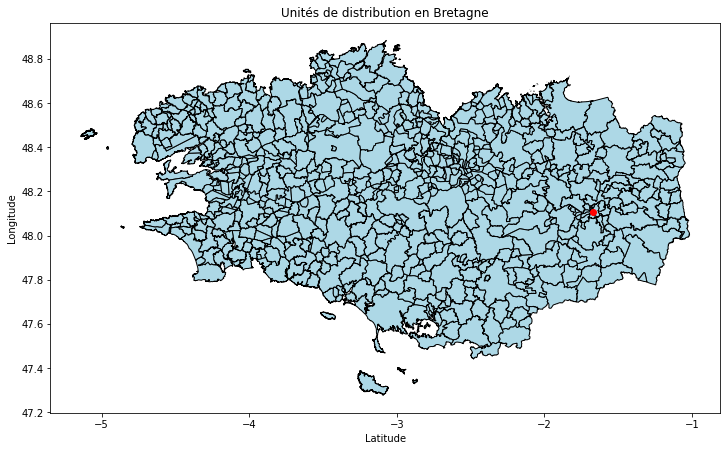

In [5]:
add = search_address(address)
p = Point(*add['geometry']['coordinates'])
code_reseau = get_code_reseau(bretagne_2016, p)
info_reseau = get_info_reseau(code_reseau)
data = get_dernier_prelevement(code_reseau)
    
# print(f"Adresse: {add['properties']['street']}, {add['properties']['city']}, {add['properties']['state']}, {add['properties']['country']}")
print(f"Adresse: {add['properties']['street']}, {add['properties']['city']}, {add['properties']['country']}")
p = Point(*add['geometry']['coordinates'])
print(f"Coordonnées: lat {p.x}, lon {p.y}")

print(f"Code de l'unité de distribution: {code_reseau}")
s = (f"{item['nom_commune']} ({item['nom_quartier']})" for item in info_reseau['data'])
print(f"Communes desservies: {', '.join(s)}")

print(f"Date du dernier prélèvement: {pd.Timestamp(data['date_prelevement'])}")
print(f"Concentration en {data['libelle_parametre']}: {data['resultat_numerique']} {data['libelle_unite']}")

#ax = df.plot('c_ins_code', cmap="Blues", figsize=(12,8))
ax = df.plot(color='lightblue', figsize=(12,8), missing_kwds={'color': 'lightgrey'}, edgecolor='black')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_title('Unités de distribution en Bretagne')
_ = ax.scatter([p.x], [p.y], color='red')